In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import pandas as pd
import scipy.signal as signal

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [3]:
#Definition filter
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.2
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


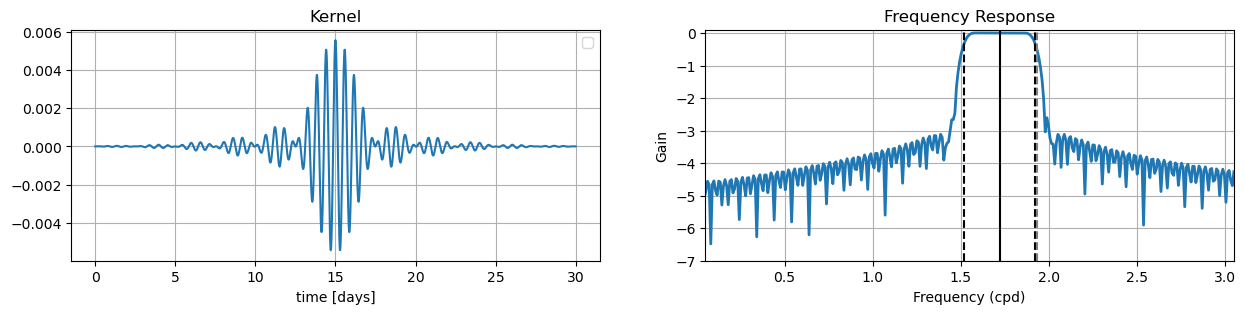

In [4]:
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega, color='k')
ax.axvline(omega-bandwidth, color='k',ls='--')
ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.9323, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [5]:
mooring=1
gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
ds = sp.wrap_filter(gridded,h,**{'hilbert':False})

In [6]:
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
ds['mld'] = mld_m1
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpu_wkb'] = ds['u_filtered']*wkb
ds['bpv_wkb'] = ds['v_filtered']*wkb
#ds.bp_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
#ds['bp_eke'] = ds.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)

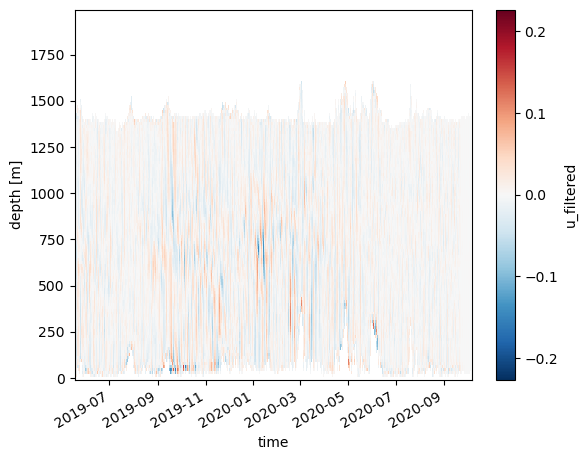

In [8]:
ds.u_filtered.plot()

In [7]:
bandwidth=None
omega=2
h_lp = ut.generate_filter('subdiurnal',dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=True)  # Best filter
hlp_hat, w = ut.filter_response(h_lp, dt=dt)  #Filter response

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


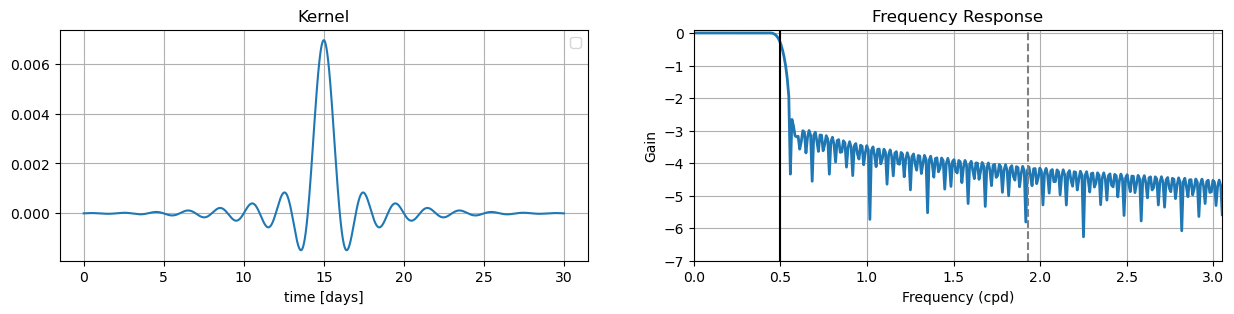

In [8]:
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h_lp)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(hlp_hat)), linewidth=2)
ax.axvline(1/omega, color='k')
#ax.axvline(omega-bandwidth, color='k',ls='--')
#ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.9323, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0., 3.05)
ax.grid(True)

In [9]:
ds_demod = sp.wrap_filter(ds,h_lp,columns=['u_filtered','v_filtered'],**{'hilbert':False})

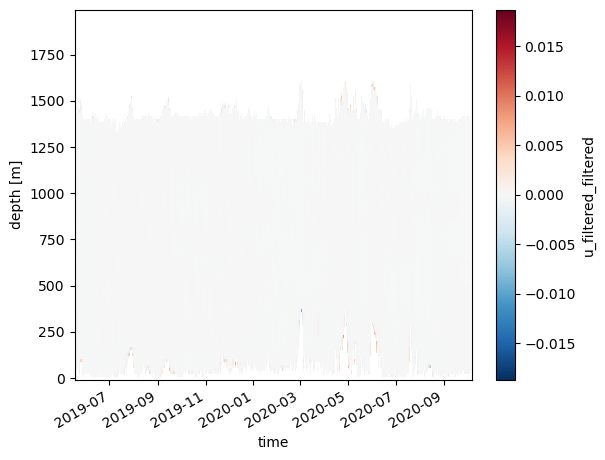

In [12]:
ds_demod.u_filtered_filtered.plot()